In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


# Data Loading

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np


%matplotlib inline

In [3]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [4]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


# Data Exploration

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [7]:
df_train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [8]:
df_train.duplicated().sum()

0

# Data Preprocessing

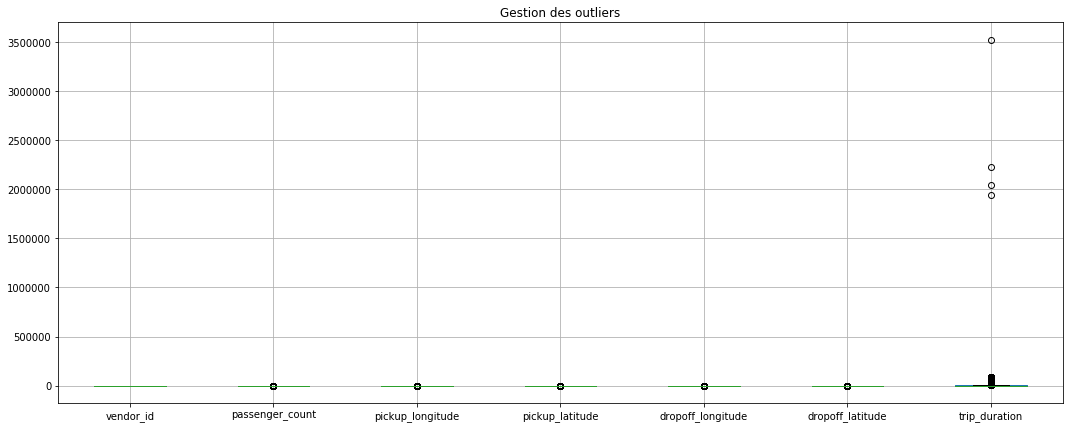

In [9]:
plt.subplots(figsize=(18,7))
plt.title("Gestion des outliers")
df_train.boxplot()

On remarque la présence de quelques outliers dans la colonne 'trip_duration', afin de ne pas fausser les données je vais sélectionner les valeurs inférieures à 150 000

In [10]:
df_train = df_train.loc[df_train['trip_duration']< 1500000]

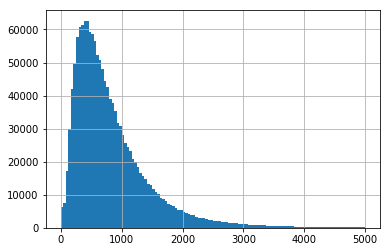

In [11]:
df_train.loc[df_train.trip_duration<5000,"trip_duration"].hist(bins=120)

On remarque que la majorité des trajets ont des durées comprises entre 0 et 4000, je vais donc réduire les trajets sélectionnés à ceux ayant des durées inférieures à 4000.

In [12]:
df_train = df_train[df_train['trip_duration']<= 4000]

### Ajout de colonnes

Création des colonnes 'pu_hour' et 'distance' à partir des données provenant de 'trip_duration', 'pickup_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'.

In [13]:
df_train = df_train[(df_train['trip_duration'] > 60) & (df_train['trip_duration'] < 3600 * 24)]

df_train['pu_hour'] = df_train['pickup_datetime'].apply(lambda x: int(x.split()[1][0:2]))

df_train['distance'] = np.sqrt((df_train['pickup_latitude']-df_train['dropoff_latitude'])**2 
                         + (df_train['pickup_longitude']-df_train['dropoff_longitude'])**2)
df_train.shape, df_test.shape

((1441573, 13), (625134, 9))

# Features Engineering

In [14]:
FEATURES = ["passenger_count", "pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude","distance","pu_hour"]
TARGET = "trip_duration"


X_train = df_train[FEATURES]
y_train = df_train[TARGET]

In [15]:
m1 = RandomForestRegressor()
m1.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [16]:
cv_scores = cross_val_score(m1, X_train, y_train, cv=5, scoring ="neg_mean_squared_log_error")
for i in range(len(cv_scores)):
    cv_scores[i] = np.sqrt(abs(cv_scores[i]))
cv_scores

array([0.37338633, 0.37062023, 0.3711409 , 0.37190255, 0.37178428])

# Prediction

In [17]:
df_test['pu_hour'] = df_test['pickup_datetime'].apply(lambda x: int(x.split()[1][0:2]))

df_test['distance'] = np.sqrt((df_test['pickup_latitude']-df_test['dropoff_latitude'])**2 + (df_test['pickup_longitude']-df_test['dropoff_longitude'])**2) 
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pu_hour,distance
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,23,0.024735
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,23,0.024979
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,23,0.013861
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,23,0.051363
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,23,0.010343


In [18]:
prediction = m1.predict(X_train)
prediction

array([ 604.6,  655.7, 1981.7, ...,  909.7,  405.2,  204.7])

In [19]:
X_prediction = df_test[["passenger_count", "pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude","distance","pu_hour"]]

In [20]:
data = m1.predict(X_prediction)

In [21]:
print(data)

[ 805.   595.   454.3 ... 1340.8 2118.7 1053.7]


# Submission

In [22]:
submission = pd.DataFrame({'id': df_test.id, 'trip_duration': data})
submission.to_csv('submission.csv', index=False)

In [23]:
submission.head()

,id,trip_duration
0,id3004672,805.0
1,id3505355,595.0
2,id1217141,454.3
3,id2150126,1046.3
4,id1598245,433.0
